# Grade Prediction Analysis - Universidad Autónoma de Chile

**Objective:** Determine feasibility of predicting student grades using LMS engagement data from Canvas.

**Data Sources:**
- Student summaries (aggregated engagement metrics)
- Enrollments (activity time, grades)
- Submissions (assignment grades, timing)
- Course activity (daily patterns)

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

DATA_DIR = '../data'

Matplotlib is building the font cache; this may take a moment.


## 1. Load Data

In [2]:
# Load all extracted data
with open(f'{DATA_DIR}/student_summaries.json') as f:
    student_summaries = json.load(f)

with open(f'{DATA_DIR}/enrollments.json') as f:
    enrollments = json.load(f)

with open(f'{DATA_DIR}/submissions.json') as f:
    submissions = json.load(f)

with open(f'{DATA_DIR}/courses_raw.json') as f:
    courses = json.load(f)

with open(f'{DATA_DIR}/assignments.json') as f:
    assignments = json.load(f)

print(f"Student summaries: {len(student_summaries)}")
print(f"Enrollments: {len(enrollments)}")
print(f"Submissions: {len(submissions)}")
print(f"Courses: {len(courses)}")
print(f"Assignments: {len(assignments)}")

Student summaries: 763
Enrollments: 753
Submissions: 14026
Courses: 97
Assignments: 394


In [3]:
# Convert to DataFrames
df_summaries = pd.DataFrame(student_summaries)
df_enrollments = pd.DataFrame(enrollments)
df_submissions = pd.DataFrame(submissions)
df_courses = pd.DataFrame(courses)
df_assignments = pd.DataFrame(assignments)

print("\nStudent Summaries columns:")
print(df_summaries.columns.tolist())

print("\nEnrollments columns:")
print(df_enrollments.columns.tolist())


Student Summaries columns:
['id', 'page_views', 'max_page_views', 'page_views_level', 'participations', 'max_participations', 'participations_level', 'tardiness_breakdown', 'course_id']

Enrollments columns:
['id', 'root_account_id', 'user_id', 'course_id', 'course_section_id', 'associated_user_id', 'limit_privileges_to_course_section', 'updated_at', 'created_at', 'start_at', 'end_at', 'type', 'enrollment_state', 'role', 'role_id', 'last_activity_at', 'last_attended_at', 'total_activity_time', 'sis_import_id', 'grades', 'sis_account_id', 'sis_course_id', 'course_integration_id', 'sis_section_id', 'section_integration_id', 'sis_user_id', 'html_url', 'user']


## 2. Explore Student Summaries

In [4]:
# Examine student summary structure
print("Sample student summary:")
print(json.dumps(student_summaries[0], indent=2))

Sample student summary:
{
  "id": 117656,
  "page_views": 1275,
  "max_page_views": 1402,
  "page_views_level": 3,
  "participations": 2,
  "max_participations": 8,
  "participations_level": 2,
  "tardiness_breakdown": {
    "missing": 9,
    "late": 0,
    "on_time": 2,
    "floating": 23,
    "total": 34
  },
  "course_id": 86689
}


In [5]:
# Extract tardiness breakdown into separate columns
if 'tardiness_breakdown' in df_summaries.columns:
    tardiness_df = pd.json_normalize(df_summaries['tardiness_breakdown'])
    tardiness_df.columns = [f'tardiness_{c}' for c in tardiness_df.columns]
    df_summaries = pd.concat([df_summaries.drop('tardiness_breakdown', axis=1), tardiness_df], axis=1)

print("\nStudent Summaries shape:", df_summaries.shape)
df_summaries.head()


Student Summaries shape: (763, 13)


,id,page_views,max_page_views,page_views_level,participations,max_participations,participations_level,course_id,tardiness_missing,tardiness_late,tardiness_on_time,tardiness_floating,tardiness_total
0,117656,1275.0,1402,3,2.0,8,2,86689,9,0,2,23,34
1,89587,1266.0,1402,3,1.0,8,2,86689,9,0,1,24,34
2,117370,1402.0,1402,3,6.0,8,3,86689,8,0,5,21,34
3,114353,411.0,1402,2,0.0,8,0,86689,9,0,0,25,34
4,117500,571.0,1402,2,0.0,8,0,86689,9,0,0,25,34


In [6]:
# Summary statistics
print("\nEngagement Statistics:")
df_summaries[['page_views', 'participations', 'page_views_level', 'participations_level']].describe()


Engagement Statistics:


,page_views,participations,page_views_level,participations_level
count,739.000000,739.000000,763.000000,763.000000
mean,378.143437,2.013532,1.942333,1.049803
std,372.531643,3.937497,0.773124,1.308215
min,1.000000,0.000000,0.000000,0.000000
25%,103.000000,0.000000,1.000000,0.000000
50%,260.000000,0.000000,2.000000,0.000000
75%,540.000000,2.000000,2.000000,2.000000
max,2813.000000,22.000000,3.000000,3.000000


## 3. Explore Enrollments & Grades

In [7]:
# Check enrollment structure
print("Sample enrollment:")
print(json.dumps(enrollments[0], indent=2)[:2000])

Sample enrollment:
{
  "id": 1915784,
  "root_account_id": 1,
  "user_id": 117656,
  "course_id": 86689,
  "course_section_id": 79791,
  "associated_user_id": null,
  "limit_privileges_to_course_section": false,
  "updated_at": "2025-07-28T14:36:24Z",
  "created_at": "2025-07-19T21:44:26Z",
  "start_at": null,
  "end_at": null,
  "type": "StudentEnrollment",
  "enrollment_state": "active",
  "role": "StudentEnrollment",
  "role_id": 3,
  "last_activity_at": "2025-11-20T11:59:45Z",
  "last_attended_at": null,
  "total_activity_time": 6030,
  "sis_import_id": 15585,
  "grades": {
    "html_url": "https://uautonoma.beta.instructure.com/courses/86689/grades/117656",
    "current_grade": null,
    "current_score": 84.07,
    "final_grade": null,
    "final_score": 32.15,
    "unposted_current_score": 84.07,
    "unposted_current_grade": null,
    "unposted_final_score": 32.15,
    "unposted_final_grade": null
  },
  "sis_account_id": "PR-PR-IECDG_111",
  "sis_course_id": "202520-14269",
  "

In [8]:
# Extract grades from enrollments
if 'grades' in df_enrollments.columns:
    grades_df = pd.json_normalize(df_enrollments['grades'])
    grades_df.columns = [f'grade_{c}' for c in grades_df.columns]
    df_enrollments = pd.concat([df_enrollments.drop('grades', axis=1), grades_df], axis=1)

# Extract user info
if 'user' in df_enrollments.columns:
    user_df = pd.json_normalize(df_enrollments['user'])
    user_df.columns = [f'user_{c}' for c in user_df.columns]
    df_enrollments = pd.concat([df_enrollments.drop('user', axis=1), user_df], axis=1)

print("\nEnrollments shape:", df_enrollments.shape)
print("\nGrade columns:")
print([c for c in df_enrollments.columns if 'grade' in c.lower() or 'score' in c.lower()])


Enrollments shape: (753, 45)

Grade columns:
['grade_html_url', 'grade_current_grade', 'grade_current_score', 'grade_final_grade', 'grade_final_score', 'grade_unposted_current_score', 'grade_unposted_current_grade', 'grade_unposted_final_score', 'grade_unposted_final_grade']



Grade Statistics:
       grade_current_score  grade_final_score  grade_unposted_current_score  \
count           181.000000         459.000000                    181.000000   
mean             86.090000          14.550610                     86.090000   
std               8.124474          20.956195                      8.124474   
min              60.000000           0.000000                     60.000000   
25%              81.060000           0.000000                     81.060000   
50%              86.540000           0.000000                     86.540000   
75%              91.850000          32.080000                     91.850000   
max             100.000000          73.890000                    100.000000   

       grade_unposted_final_score  
count                  459.000000  
mean                    14.550610  
std                     20.956195  
min                      0.000000  
25%                      0.000000  
50%                      0.000000  
75%              

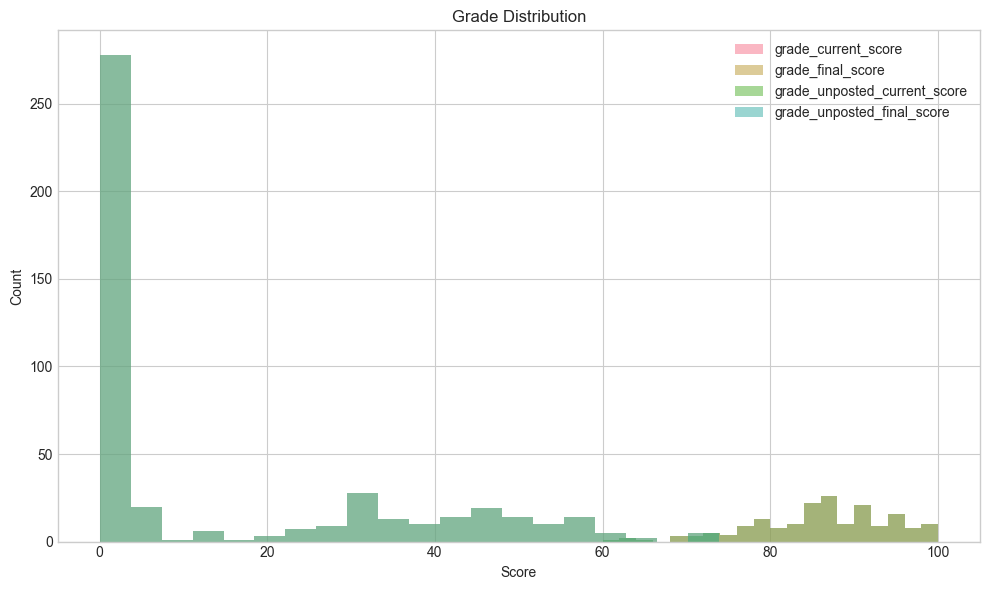

In [15]:
# Check grade distribution
grade_cols = [c for c in df_enrollments.columns if 'current_score' in c or 'final_score' in c]
if grade_cols:
    print("\nGrade Statistics:")
    print(df_enrollments[grade_cols].describe())
    
    # Plot grade distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    for col in grade_cols:
        if df_enrollments[col].notna().sum() > 0:
            df_enrollments[col].dropna().hist(bins=20, alpha=0.5, label=col, ax=ax)
    ax.set_xlabel('Score')
    ax.set_ylabel('Count')
    ax.set_title('Grade Distribution')
    ax.legend()
    plt.tight_layout()
    plt.show()

## 4. Merge Data for Analysis

In [17]:
# Identify common keys
print("Student Summaries ID column:", 'id' in df_summaries.columns)
print("Enrollments user_id column:", 'user_id' in df_enrollments.columns)

# Rename for consistency
df_summaries_renamed = df_summaries.rename(columns={'id': 'user_id'})

# Merge summaries with enrollments
df_merged = df_summaries_renamed.merge(
    df_enrollments[['user_id', 'course_id', 'total_activity_time', 'last_activity_at'] + 
                   [c for c in df_enrollments.columns if 'grade_' in c or 'score' in c.lower()]],
    on=['user_id', 'course_id'],
    how='inner'
)

print(f"\nMerged dataset: {len(df_merged)} student-course records")
df_merged.head()

Student Summaries ID column: True
Enrollments user_id column: True


ValueError: The column label 'user_id' is not unique.

In [18]:
# Check available features
print("\nAvailable features:")
for col in df_merged.columns:
    non_null = df_merged[col].notna().sum()
    print(f"  {col}: {non_null}/{len(df_merged)} non-null")


Available features:


NameError: name 'df_merged' is not defined

## 5. Feature Engineering

In [ ]:
# Calculate submission-based features per student-course
df_sub = df_submissions.copy()

# Submission statistics per student per course
sub_stats = df_sub.groupby(['user_id', 'course_id']).agg({
    'id': 'count',
    'score': ['mean', 'std', 'max', 'min'],
    'late': 'sum',
    'missing': 'sum',
    'excused': 'sum'
}).reset_index()

# Flatten column names
sub_stats.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in sub_stats.columns]
sub_stats.columns = ['user_id', 'course_id', 'submission_count', 'score_mean', 'score_std', 
                     'score_max', 'score_min', 'late_count', 'missing_count', 'excused_count']

print(f"Submission stats: {len(sub_stats)} student-course pairs")
sub_stats.head()

In [ ]:
# Merge submission stats with main dataset
df_analysis = df_merged.merge(sub_stats, on=['user_id', 'course_id'], how='left')

# Calculate derived features
df_analysis['late_pct'] = df_analysis['late_count'] / df_analysis['submission_count'].replace(0, np.nan)
df_analysis['missing_pct'] = df_analysis['missing_count'] / df_analysis['submission_count'].replace(0, np.nan)

# Engagement score (composite)
df_analysis['engagement_score'] = (
    df_analysis['page_views_level'] * 0.3 +
    df_analysis['participations_level'] * 0.3 +
    (1 - df_analysis['late_pct'].fillna(0)) * 0.2 +
    (1 - df_analysis['missing_pct'].fillna(0)) * 0.2
) * 25  # Scale to 0-100

print(f"\nAnalysis dataset: {len(df_analysis)} records with {len(df_analysis.columns)} features")
df_analysis.head()

## 6. Correlation Analysis

In [ ]:
# Select numeric features for correlation
feature_cols = [
    'page_views', 'page_views_level', 'participations', 'participations_level',
    'tardiness_on_time', 'tardiness_late', 'tardiness_missing',
    'total_activity_time', 'submission_count', 'score_mean',
    'late_count', 'missing_count', 'late_pct', 'missing_pct', 'engagement_score'
]

# Find the target variable (current score or final score)
target_candidates = [c for c in df_analysis.columns if 'current_score' in c.lower() or 'final_score' in c.lower()]
if target_candidates:
    target_col = target_candidates[0]
    print(f"Target variable: {target_col}")
else:
    target_col = 'score_mean'
    print(f"Using submission score mean as target: {target_col}")

# Available features
available_features = [c for c in feature_cols if c in df_analysis.columns and c != target_col]
print(f"\nAvailable features: {available_features}")

In [ ]:
# Correlation with target
correlations = df_analysis[available_features + [target_col]].corr()[target_col].drop(target_col).sort_values(ascending=False)

print(f"\nCorrelation with {target_col}:")
print(correlations)

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['green' if x > 0 else 'red' for x in correlations.values]
correlations.plot(kind='barh', ax=ax, color=colors)
ax.set_xlabel('Correlation Coefficient')
ax.set_title(f'Feature Correlation with {target_col}')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Correlation heatmap
corr_matrix = df_analysis[available_features + [target_col]].corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', ax=ax)
ax.set_title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## 7. Predictive Modeling

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Prepare data for modeling
model_features = [c for c in available_features if c != 'score_mean']  # Exclude direct score features

# Create clean dataset
df_model = df_analysis[model_features + [target_col]].dropna()
print(f"Model dataset: {len(df_model)} complete records")

X = df_model[model_features]
y = df_model[target_col]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

In [ ]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

# Train and evaluate
results = []

for name, model in models.items():
    # Use scaled data for linear models
    if 'Regression' in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    })
    
    print(f"\n{name}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R2: {r2:.3f}")

df_results = pd.DataFrame(results)
df_results

In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['RMSE', 'MAE', 'R2']
colors = sns.color_palette('husl', len(df_results))

for ax, metric in zip(axes, metrics):
    bars = ax.bar(df_results['Model'], df_results[metric], color=colors)
    ax.set_ylabel(metric)
    ax.set_title(f'Model Comparison: {metric}')
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for bar, val in zip(bars, df_results[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                f'{val:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [ ]:
# Feature importance from Random Forest
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'Feature': model_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(feature_importance)

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature', ax=ax, palette='viridis')
ax.set_title('Feature Importance for Grade Prediction')
plt.tight_layout()
plt.show()

In [ ]:
# Predicted vs Actual plot for best model
best_model_name = df_results.loc[df_results['R2'].idxmax(), 'Model']
best_model = models[best_model_name]

if 'Regression' in best_model_name:
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(y_test, y_pred_best, alpha=0.5)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
ax.set_xlabel('Actual Score')
ax.set_ylabel('Predicted Score')
ax.set_title(f'Predicted vs Actual Grades ({best_model_name})')
ax.legend()
plt.tight_layout()
plt.show()

## 8. Cross-Validation

In [ ]:
# Cross-validation for best models
print("5-Fold Cross-Validation Results:")
print("="*50)

for name in ['Random Forest', 'Gradient Boosting']:
    model = models[name]
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(f"\n{name}:")
    print(f"  R2 scores: {scores}")
    print(f"  Mean R2: {scores.mean():.3f} (+/- {scores.std()*2:.3f})")

## 9. Key Insights & Conclusions

In [ ]:
# Summary statistics
print("="*60)
print("GRADE PREDICTION FEASIBILITY ANALYSIS - SUMMARY")
print("="*60)

print(f"\n1. DATA OVERVIEW:")
print(f"   - Total student-course records: {len(df_analysis)}")
print(f"   - Complete records for modeling: {len(df_model)}")
print(f"   - Courses analyzed: {df_analysis['course_id'].nunique()}")
print(f"   - Unique students: {df_analysis['user_id'].nunique()}")

print(f"\n2. BEST PREDICTIVE MODEL:")
best_idx = df_results['R2'].idxmax()
print(f"   - Model: {df_results.loc[best_idx, 'Model']}")
print(f"   - R2 Score: {df_results.loc[best_idx, 'R2']:.3f}")
print(f"   - RMSE: {df_results.loc[best_idx, 'RMSE']:.2f} points")
print(f"   - MAE: {df_results.loc[best_idx, 'MAE']:.2f} points")

print(f"\n3. TOP PREDICTIVE FEATURES:")
for i, row in feature_importance.head(5).iterrows():
    print(f"   - {row['Feature']}: {row['Importance']:.3f}")

print(f"\n4. STRONGEST CORRELATIONS WITH GRADES:")
top_corr = correlations.head(5)
for feat, corr in top_corr.items():
    print(f"   - {feat}: r={corr:.3f}")

print(f"\n5. CONCLUSION:")
r2_best = df_results.loc[best_idx, 'R2']
if r2_best > 0.5:
    print(f"   FEASIBLE: LMS engagement data can explain {r2_best*100:.1f}% of grade variance.")
    print("   The model shows strong predictive power for early warning systems.")
elif r2_best > 0.3:
    print(f"   MODERATELY FEASIBLE: LMS data explains {r2_best*100:.1f}% of grade variance.")
    print("   Useful for identifying at-risk students but not for precise predictions.")
else:
    print(f"   LIMITED FEASIBILITY: LMS data only explains {r2_best*100:.1f}% of grade variance.")
    print("   Other factors (prior knowledge, external study, etc.) may be more important.")

In [ ]:
# Save analysis results
results_summary = {
    'total_records': len(df_analysis),
    'model_records': len(df_model),
    'courses': int(df_analysis['course_id'].nunique()),
    'students': int(df_analysis['user_id'].nunique()),
    'best_model': df_results.loc[best_idx, 'Model'],
    'best_r2': float(df_results.loc[best_idx, 'R2']),
    'best_rmse': float(df_results.loc[best_idx, 'RMSE']),
    'best_mae': float(df_results.loc[best_idx, 'MAE']),
    'top_features': feature_importance.head(5).to_dict('records'),
    'model_comparison': df_results.to_dict('records')
}

with open(f'{DATA_DIR}/grade_prediction_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"\nResults saved to {DATA_DIR}/grade_prediction_results.json")